# Kwanza Tukule Data Analysis Assessment Workflow

In [1]:
!pip install statsmodels --upgrade
!pip install scipy

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
from datetime import datetime, timedelta
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import mean_absolute_percentage_error
from statsmodels.tsa.arima.model import ARIMA
import scipy.stats as stats

import warnings
warnings.filterwarnings("ignore")

## Section 1: Data Cleaning and Preparation

In [29]:
data = pd.read_excel("Case Study Data - Read Only.xlsx")
#remove duplicates
data.drop_duplicates(inplace=True)
print(f"Shape: {data.shape}")
print(data.info())
data.head()

Shape: (329881, 7)
<class 'pandas.core.frame.DataFrame'>
Index: 329881 entries, 0 to 333404
Data columns (total 7 columns):
 #   Column               Non-Null Count   Dtype         
---  ------               --------------   -----         
 0   DATE                 329881 non-null  datetime64[ns]
 1   ANONYMIZED CATEGORY  329881 non-null  object        
 2   ANONYMIZED PRODUCT   329881 non-null  object        
 3   ANONYMIZED BUSINESS  329881 non-null  object        
 4   ANONYMIZED LOCATION  329881 non-null  object        
 5   QUANTITY             329881 non-null  int64         
 6   UNIT PRICE           329873 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1), object(4)
memory usage: 20.1+ MB
None


,DATE,ANONYMIZED CATEGORY,ANONYMIZED PRODUCT,ANONYMIZED BUSINESS,ANONYMIZED LOCATION,QUANTITY,UNIT PRICE
0,2024-08-18 21:32:00,Category-106,Product-21f4,Business-de42,Location-1ba8,1,850.00
1,2024-08-18 21:32:00,Category-120,Product-4156,Business-de42,Location-1ba8,2,1910.00
2,2024-08-18 21:32:00,Category-121,Product-49bd,Business-de42,Location-1ba8,1,3670.00
3,2024-08-18 21:32:00,Category-76,Product-61dd,Business-de42,Location-1ba8,1,2605.00
4,2024-08-18 21:32:00,Category-119,Product-66e0,Business-de42,Location-1ba8,5,1480.00


### Data Quality Assessment

The data looks good apart from 8 missing records in the UNIT PRICE column.

In [30]:
missing_data = data[data["UNIT PRICE"].isna()]
missing_data

,DATE,ANONYMIZED CATEGORY,ANONYMIZED PRODUCT,ANONYMIZED BUSINESS,ANONYMIZED LOCATION,QUANTITY,UNIT PRICE
108112,2024-07-03 17:53:00,Category-94,Product-3d7f,Business-4fce,Location-f37d,2,NaN
150961,2024-12-16 18:33:00,Category-79,Product-dfc8,Business-8bbf,Location-3fc0,1,NaN
151142,2024-12-22 14:42:00,Category-122,Product-15e0,Business-c575,Location-1979,3,NaN
272379,2024-06-27 12:15:00,Category-92,Product-ccbc,Business-14b6,Location-1979,1,NaN
278284,2024-08-14 21:09:00,Category-101,Product-84a5,Business-4be1,Location-bb69,21,NaN
278384,2024-12-30 14:17:00,Category-95,Product-15f3,Business-1a74,Location-f37d,1,NaN
310385,2024-03-31 14:03:00,Category-114,Product-9204,Business-c9dc,Location-689f,1,NaN
327152,2024-08-13 16:20:00,Category-107,Product-7eed,Business-0d61,Location-1ba8,1,NaN


In [5]:
# Impute missing "UNIT PRICE" using available prices where "ANONYMIZED PRODUCT" and "ANONIMIZED LOCATION" matches
for index, row in data[data["UNIT PRICE"].isna()].iterrows():
    product = row["ANONYMIZED PRODUCT"]
    location = row["ANONYMIZED LOCATION"]
    # Find matching rows with non-missing "UNIT PRICE"
    matching_rows = data[(data["ANONYMIZED PRODUCT"] == product) & (data["ANONYMIZED LOCATION"] == location) & (~data["UNIT PRICE"].isna())]
    if not matching_rows.empty:
        # Impute with the mode of matching prices
        data.loc[index, "UNIT PRICE"] = matching_rows["UNIT PRICE"].mode()[0]
    else:
        # If no matches are found for BOTH product and location, find the modal price for that product across all locations
        product_modal_price = data[data["ANONYMIZED PRODUCT"] == product]["UNIT PRICE"].mode()
        if not product_modal_price.empty:
            data.loc[index, "UNIT PRICE"] = product_modal_price[0]
        else:
            category = row["ANONYMIZED CATEGORY"]
            # If no modal price is found for the product, i.e. if it is the only product in the data, use the overall mean of product's ANONYMIZED CATEGORY as a last resort.
            category_mean = data[data["ANONYMIZED CATEGORY"] == category]["UNIT PRICE"].mean()
            data.loc[index, "UNIT PRICE"] = category_mean

# Verify the imputation
missing_data_after_imputation = data[data["UNIT PRICE"].isna()]
print(f"Number of missing 'UNIT PRICE' after imputation: {missing_data_after_imputation.shape[0]} \n")
data.info()

Number of missing 'UNIT PRICE' after imputation: 0 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 333405 entries, 0 to 333404
Data columns (total 7 columns):
 #   Column               Non-Null Count   Dtype         
---  ------               --------------   -----         
 0   DATE                 333405 non-null  datetime64[ns]
 1   ANONYMIZED CATEGORY  333405 non-null  object        
 2   ANONYMIZED PRODUCT   333405 non-null  object        
 3   ANONYMIZED BUSINESS  333405 non-null  object        
 4   ANONYMIZED LOCATION  333405 non-null  object        
 5   QUANTITY             333405 non-null  int64         
 6   UNIT PRICE           333405 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1), object(4)
memory usage: 17.8+ MB


### Feature Engineering

In [6]:
# Extract month and year
data["MONTH-YEAR"] = data["DATE"].dt.strftime("%B-%Y")
print(data.info())
data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 333405 entries, 0 to 333404
Data columns (total 8 columns):
 #   Column               Non-Null Count   Dtype         
---  ------               --------------   -----         
 0   DATE                 333405 non-null  datetime64[ns]
 1   ANONYMIZED CATEGORY  333405 non-null  object        
 2   ANONYMIZED PRODUCT   333405 non-null  object        
 3   ANONYMIZED BUSINESS  333405 non-null  object        
 4   ANONYMIZED LOCATION  333405 non-null  object        
 5   QUANTITY             333405 non-null  int64         
 6   UNIT PRICE           333405 non-null  float64       
 7   MONTH-YEAR           333405 non-null  object        
dtypes: datetime64[ns](1), float64(1), int64(1), object(5)
memory usage: 20.3+ MB
None


,DATE,ANONYMIZED CATEGORY,ANONYMIZED PRODUCT,ANONYMIZED BUSINESS,ANONYMIZED LOCATION,QUANTITY,UNIT PRICE,MONTH-YEAR
0,2024-08-18 21:32:00,Category-106,Product-21f4,Business-de42,Location-1ba8,1,850.0,August-2024
1,2024-08-18 21:32:00,Category-120,Product-4156,Business-de42,Location-1ba8,2,1910.0,August-2024
2,2024-08-18 21:32:00,Category-121,Product-49bd,Business-de42,Location-1ba8,1,3670.0,August-2024
3,2024-08-18 21:32:00,Category-76,Product-61dd,Business-de42,Location-1ba8,1,2605.0,August-2024
4,2024-08-18 21:32:00,Category-119,Product-66e0,Business-de42,Location-1ba8,5,1480.0,August-2024


## Section 2: Exploratory Data Analysis

### Sales Overview

In [7]:
# Calculate "VALUE" columns as QUANTITY * UNIT PRICE
data["VALUE"] = data["QUANTITY"] * data["UNIT PRICE"]
data["VALUE"] = data["VALUE"].astype(int)
data.head(3)

,DATE,ANONYMIZED CATEGORY,ANONYMIZED PRODUCT,ANONYMIZED BUSINESS,ANONYMIZED LOCATION,QUANTITY,UNIT PRICE,MONTH-YEAR,VALUE
0,2024-08-18 21:32:00,Category-106,Product-21f4,Business-de42,Location-1ba8,1,850.0,August-2024,850
1,2024-08-18 21:32:00,Category-120,Product-4156,Business-de42,Location-1ba8,2,1910.0,August-2024,3820
2,2024-08-18 21:32:00,Category-121,Product-49bd,Business-de42,Location-1ba8,1,3670.0,August-2024,3670


#### Sales by Category

In [8]:
# Group by 'ANONYMIZED CATEGORY' and calculate total quantity and value
categorical_sales = data.groupby("ANONYMIZED CATEGORY").agg({"QUANTITY": "sum", "VALUE": "sum"})
categorical_sales.rename(columns={"QUANTITY": "TOTAL QUANTITY", "VALUE": "TOTAL VALUE"}, inplace=True)

print(f"Total Categories: {categorical_sales.shape[0]}")
#categorical_sales.head(10)

Total Categories: 46


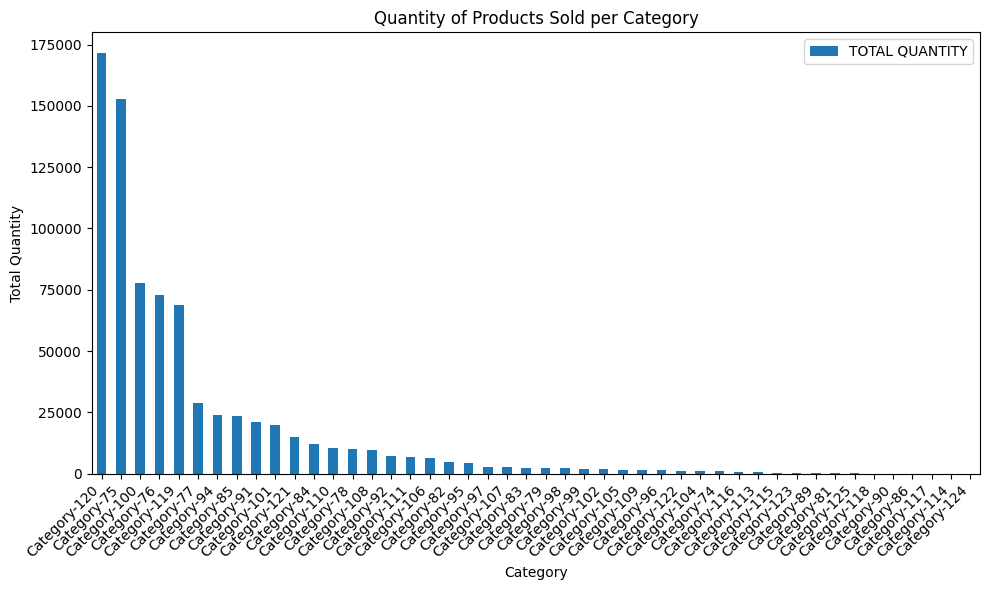

In [9]:
# Plot a graph of QUANTITY against CATEGORIES
# Sort
categorical_sales_sorted = categorical_sales.sort_values(by="TOTAL QUANTITY", ascending=False)
# Plot
categorical_sales_sorted.plot(y="TOTAL QUANTITY", kind="bar", figsize=(10, 6))
plt.title("Quantity of Products Sold per Category")
plt.xlabel("Category")
plt.ylabel("Total Quantity")
plt.xticks(rotation=45, ha='right')
plt.tight_layout();

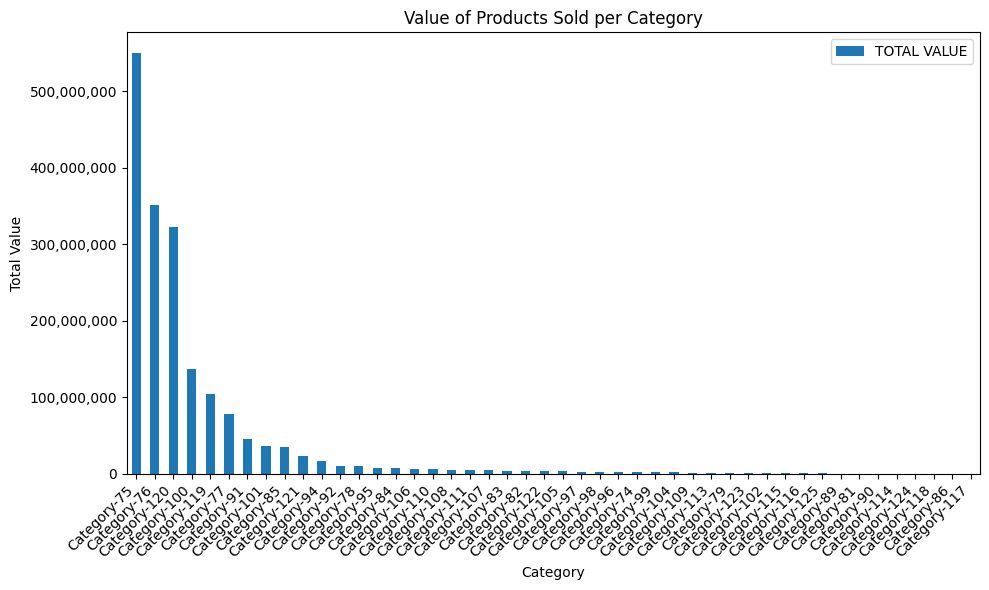

In [10]:
# Plot a graph of VALUE against CATEGORIES
# Sort
categorical_sales_sorted = categorical_sales.sort_values(by="TOTAL VALUE", ascending=False)
# Plot
categorical_sales_sorted.plot(y="TOTAL VALUE", kind="bar", figsize=(10, 6))
plt.title("Value of Products Sold per Category")
plt.xlabel("Category")
plt.ylabel("Total Value")
plt.xticks(rotation=45, ha='right')
# Format the y-axis to display numbers with commas
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f"{int(x):,}"))
plt.tight_layout();

#### Sales by Business

In [11]:
# Group by 'ANONYMIZED BUSINESS' and calculate total quantity and value
business_sales = data.groupby("ANONYMIZED BUSINESS").agg({"QUANTITY": "sum", "VALUE": "sum"})
business_sales.rename(columns={"QUANTITY": "TOTAL QUANTITY", "VALUE": "TOTAL VALUE"}, inplace=True)
print(f"Total Unique Businesses: {business_sales.shape[0]}")
business_sales.head(10)

Total Unique Businesses: 4800


,TOTAL QUANTITY,TOTAL VALUE
ANONYMIZED BUSINESS,,
Business-0000,8,10445
Business-0005,1,2645
Business-0029,26,77340
Business-003d,98,221761
Business-0072,127,225056
Business-0078,333,1108125
Business-007a,2,4010
Business-0086,6,11200
Business-00a2,9,20685


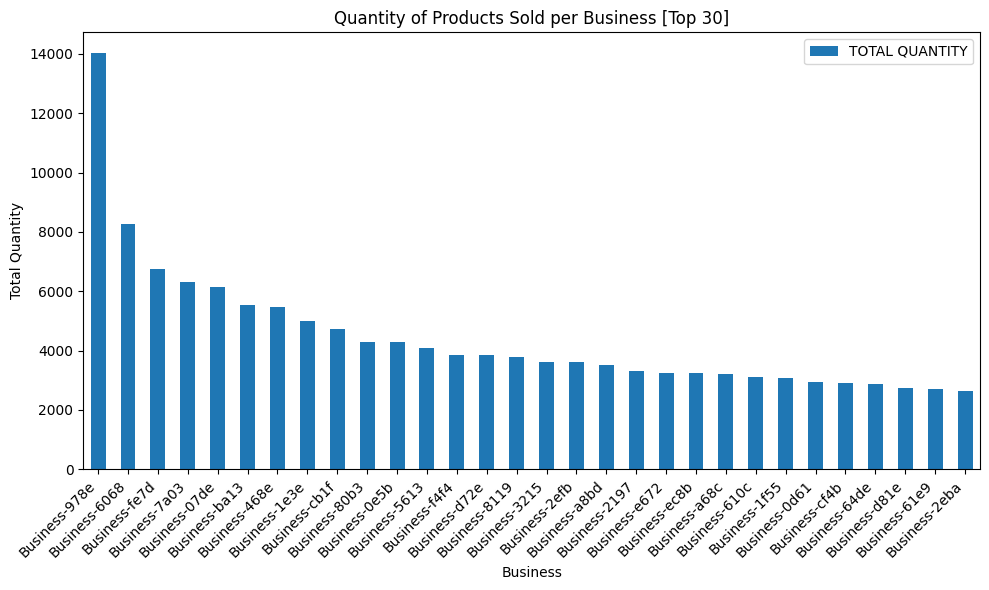

In [12]:
# plot a graph of quantity against business
# Sort
business_sales_sorted = business_sales.sort_values(by="TOTAL QUANTITY", ascending=False)
# Plot Top 30 Businesses
business_sales_sorted.head(30).plot(y="TOTAL QUANTITY", kind="bar", figsize=(10, 6))
plt.title("Quantity of Products Sold per Business [Top 30]")
plt.xlabel("Business")
plt.ylabel("Total Quantity")
plt.xticks(rotation=45, ha='right')
plt.tight_layout();

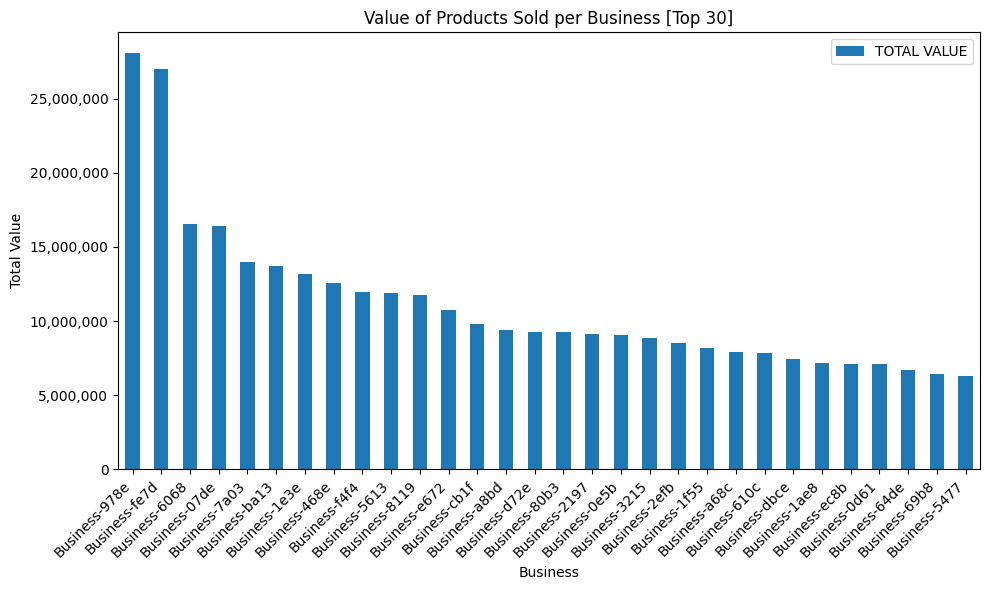

In [13]:
# plot a graph of Total Value against Business
# Sort
business_sales_sorted = business_sales.sort_values(by="TOTAL VALUE", ascending=False)
# Plot Top 30 Businesses
business_sales_sorted.head(30).plot(y="TOTAL VALUE", kind="bar", figsize=(10, 6))
plt.title("Value of Products Sold per Business [Top 30]")
plt.xlabel("Business")
plt.ylabel("Total Value")
plt.xticks(rotation=45, ha='right')
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f"{int(x):,}"))
plt.tight_layout();

#### Sales Trend over Time

In [14]:
# PREPARE MONTHLY SALES DATA
def prepare_monthly_sales_data(df):
    data["MONTH-YEAR"] = pd.to_datetime(data["MONTH-YEAR"])
    # Group data by month-year and calculate total sales value and quantity
    monthly_sales = data.groupby(data["MONTH-YEAR"].dt.to_period('M')).agg({"VALUE": "sum", "QUANTITY": "sum"}).reset_index()
    monthly_sales["MONTH-YEAR"] = monthly_sales["MONTH-YEAR"].dt.to_timestamp()

    monthly_sales.set_index("MONTH-YEAR", inplace=True)

    return monthly_sales

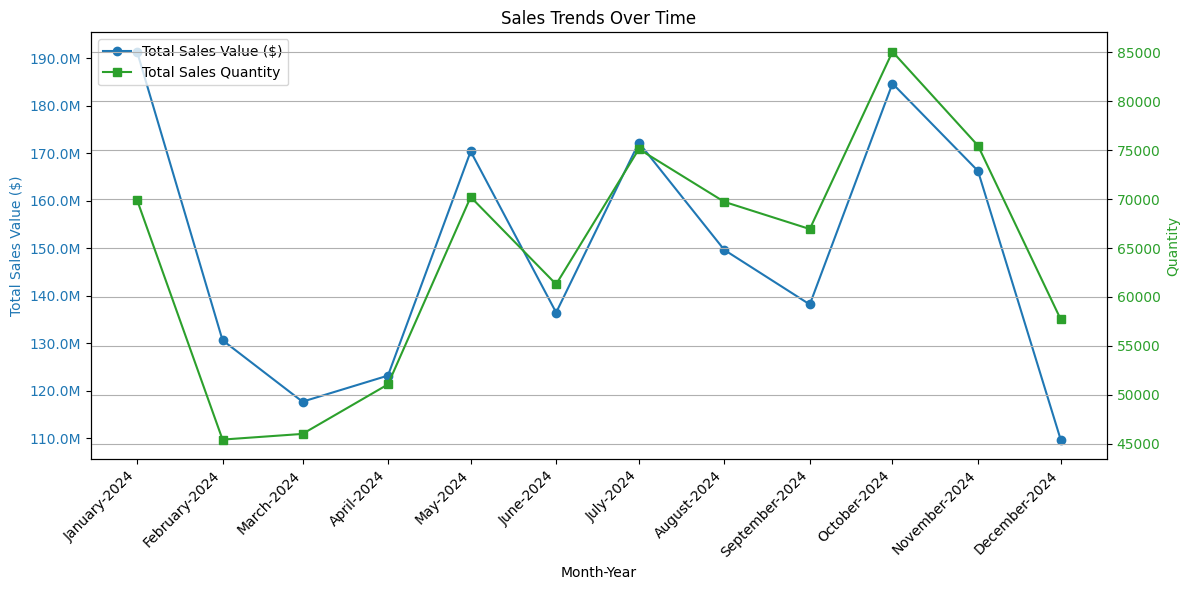

In [15]:
monthly_sales = prepare_monthly_sales_data(data)

# PLOT

# Create two plots (side-by-side)
fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot 1 [Primary Axis]: Value
color = "tab:blue"
ax1.set_xlabel("Month-Year")
ax1.set_ylabel("Total Sales Value ($)", color=color)
line1 = ax1.plot(monthly_sales.index, monthly_sales["VALUE"], color=color, marker='o', label="Total Sales Value ($)")
ax1.tick_params(axis='y', labelcolor=color)
# Format x-axis ticks
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%B-%Y'))
plt.xticks(rotation=45, ha='right')
# Format y-axis ticks to show values in millions
ax1.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f"{x / 1_000_000:.1f}M"))

# Plot 2: Quantity
ax2 = ax1.twinx()
color2 = "tab:green"
ax2.set_ylabel("Quantity", color=color2)
line2 = ax2.plot(monthly_sales.index, monthly_sales["QUANTITY"], color=color2, marker='s', label="Total Sales Quantity")
ax2.tick_params(axis='y', labelcolor=color2)

# Adjust the number of x-ticks
ax1.xaxis.set_major_locator(mdates.MonthLocator())

# Add legend and Title
lines = line1 + line2
labels = [l.get_label() for l in lines]
ax1.legend(lines, labels, loc='upper left')
plt.grid(True)
plt.title("Sales Trends Over Time")

plt.tight_layout()
plt.show()

#### Performance Analysis

##### Top 5 Most Frequently purchased product based on quantity
Identifying the top 5 most frequently purchased product based on quantity, FACTORING IN that not every business will buy all the products
Frequency = Quantity purchased / Unique purchases (business)

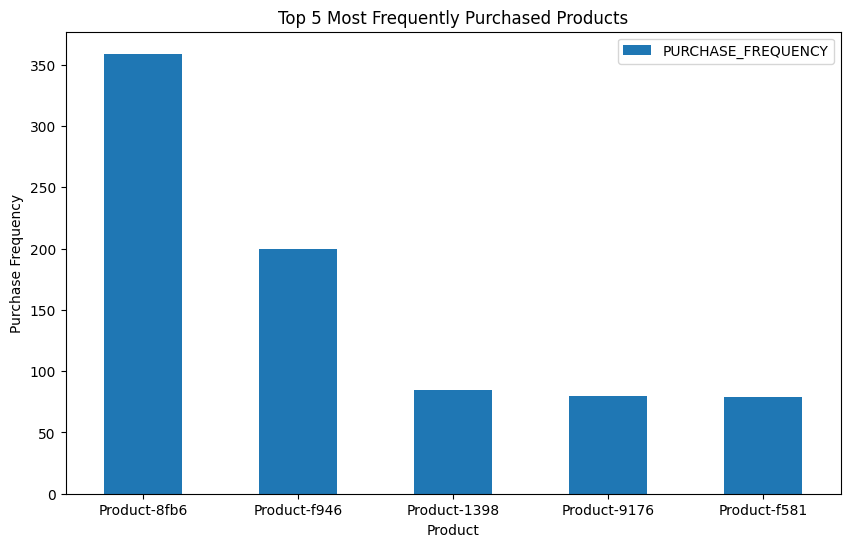

In [16]:
# Calculate the total quantity of each product purchased by all businesses
product_business_quantity = data.groupby("ANONYMIZED PRODUCT").agg("QUANTITY").sum().reset_index()
# Calculate the total number of unique businesses that purchased each product
product_business_count = data.groupby("ANONYMIZED PRODUCT").agg("ANONYMIZED BUSINESS").nunique().reset_index()
# Merge the two DataFrames
merged_data = pd.merge(product_business_quantity, product_business_count, on="ANONYMIZED PRODUCT")
# Rename columns for clarity
merged_data.rename(columns={"QUANTITY": "TOTAL_QUANTITY", "ANONYMIZED BUSINESS": "BUSINESS_COUNT"}, inplace=True)

# Calculate the frequency of purchase for each product
merged_data["PURCHASE_FREQUENCY"] = merged_data["TOTAL_QUANTITY"] / merged_data["BUSINESS_COUNT"]

# Extract product and purchase frequencies
product_frequency = merged_data[["ANONYMIZED PRODUCT", "PURCHASE_FREQUENCY"]].set_index("ANONYMIZED PRODUCT")
# Sort by frequency in descending order and get the top 5
top_5_products = product_frequency.sort_values("PURCHASE_FREQUENCY", ascending=False).head(5)

# Plot
top_5_products.plot(y="PURCHASE_FREQUENCY", kind="bar", figsize=(10, 6))
plt.title("Top 5 Most Frequently Purchased Products")
plt.xlabel("Product")
plt.ylabel("Purchase Frequency")
plt.xticks(rotation=0, ha='center');

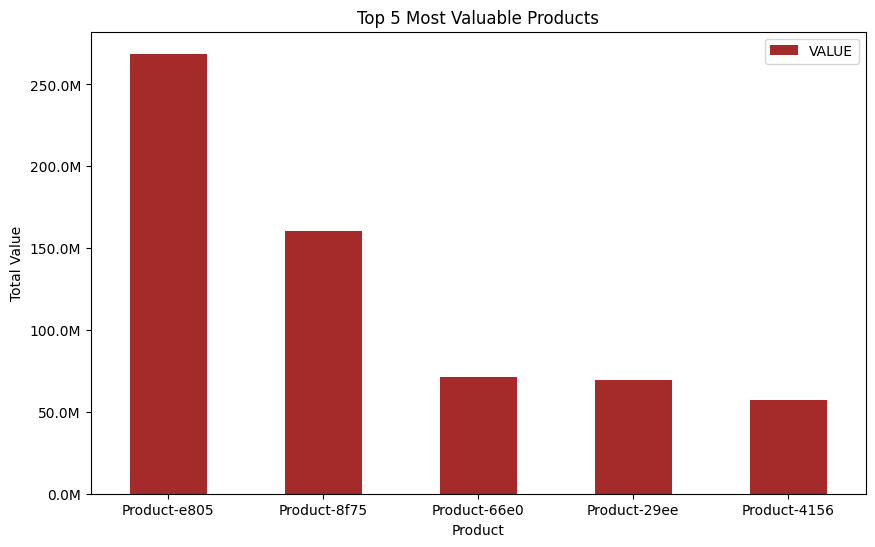

In [17]:
# identifying the top 5 most valuable products based on value
top_5_value_products = data.groupby("ANONYMIZED PRODUCT").agg({"VALUE": "sum"}).sort_values(by="VALUE", ascending=False).head(5)
top_5_value_products

# Plot
top_5_value_products.plot(y="VALUE", kind="bar", figsize=(10, 6), color="brown")
plt.title("Top 5 Most Valuable Products")
plt.xlabel("Product")
plt.ylabel("Total Value")
plt.xticks(rotation=0, ha='center')
#
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f"{x / 1_000_000:.1f}M"));

## Section 3: Advanced Analysis

### 1. Customer Segmentation

Select Features useful in CUSTOMER SEGMENTATION

In [18]:
business_metrics = data.groupby('ANONYMIZED BUSINESS').agg({
        'DATE': 'count',  # Frequency
        'QUANTITY': 'sum',  # Total Quantity
        'UNIT PRICE': lambda x: (x * data.loc[x.index, 'QUANTITY']).sum()  # Total Value
    }).rename(columns={
        'DATE': 'frequency',
        'QUANTITY': 'total_quantity',
        'UNIT PRICE': 'total_value'
    })

business_metrics.head()

,frequency,total_quantity,total_value
ANONYMIZED BUSINESS,,,
Business-0000,8,8,10445.0
Business-0005,1,1,2645.0
Business-0029,6,26,77340.0
Business-003d,31,98,221761.0
Business-0072,101,127,225056.0


In [19]:
def perform_customer_segmentation(df, n_clusters=3):
    business_metrics = df.groupby('ANONYMIZED BUSINESS').agg({
        'DATE': 'count',  # Frequency
        'QUANTITY': 'sum',  # Total Quantity
        'UNIT PRICE': lambda x: (x * df.loc[x.index, 'QUANTITY']).sum()  # Total Value
    }).rename(columns={
        'DATE': 'frequency',
        'QUANTITY': 'total_quantity',
        'UNIT PRICE': 'total_value'
    })

    # Prepare features for clustering
    features = ['frequency', 'total_quantity', 'total_value']
    X = business_metrics[features].values

    # Scale the features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # Perform K-means clustering on scaled original features
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    business_metrics['cluster'] = kmeans.fit_predict(X_scaled)

    # Apply PCA (for visualization only)
    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(X_scaled)

    # Add PCA coordinates to business_metrics for visualization
    business_metrics['PCA1'] = X_pca[:, 0]
    business_metrics['PCA2'] = X_pca[:, 1]

    # Map clusters to segments based on total value
    cluster_means = business_metrics.groupby('cluster')['total_value'].mean()
    cluster_mapping = dict(zip(
        cluster_means.sort_values().index,
        ['Low', 'Medium', 'High']
    ))
    business_metrics['segment'] = business_metrics['cluster'].map(cluster_mapping)

    return business_metrics, X_scaled, X_pca, kmeans, pca.explained_variance_ratio_

def plot_segmentation_results(business_metrics, X_pca, kmeans, explained_variance):
    # Create figure with subplots
    fig = plt.figure(figsize=(15, 5))

    # 1. PCA visualization of clusters
    plt.subplot(131)
    scatter = plt.scatter(
        X_pca[:, 0],
        X_pca[:, 1],
        c=kmeans.labels_,
        cmap='viridis',
        alpha=0.6
    )
    plt.xlabel(f'First PC ({explained_variance[0]:.1%} variance)')
    plt.ylabel(f'Second PC ({explained_variance[1]:.1%} variance)')
    plt.title('Customer Segments (PCA Visualization)')

    # 2. Value distribution by segment
    plt.subplot(132)
    sns.boxplot(
        data=business_metrics,
        x='segment',
        y='total_value',
        order=['Low', 'Medium', 'High']
    )
    plt.title('Value Distribution by Segment')
    plt.yscale('log')
    plt.ylabel('Total Value (log scale)')

    # 3. Frequency vs Quantity colored by segment
    plt.subplot(133)
    for segment in ['Low', 'Medium', 'High']:
        mask = business_metrics['segment'] == segment
        plt.scatter(
            business_metrics[mask]['frequency'],
            business_metrics[mask]['total_quantity'],
            alpha=0.6,
            label=segment
        )
    plt.xlabel('Frequency')
    plt.ylabel('Total Quantity')
    plt.title('Frequency vs Quantity by Segment')
    plt.legend()

    plt.tight_layout()
    return fig

def analyze_segments(business_metrics):
    # Calculate segment statistics
    segment_stats = pd.DataFrame()

    for segment in ['Low', 'Medium', 'High']:
        segment_data = business_metrics[business_metrics['segment'] == segment]
        stats = {
            'Customer Count': len(segment_data),
            'Customer %': (len(segment_data) / len(business_metrics)) * 100,
            'Avg Frequency': segment_data['frequency'].mean(),
            'Avg Quantity': segment_data['total_quantity'].mean(),
            'Avg Value': f"{segment_data['total_value'].mean():,.2f}",
            'Total Value %': (segment_data['total_value'].sum() / business_metrics['total_value'].sum()) * 100,
            'Avg Order Size': (segment_data['total_value'] / segment_data['frequency']).mean()
        }
        segment_stats[segment] = pd.Series(stats)

    return segment_stats.round(2)

def get_segment_characteristics(business_metrics):
    characteristics = {}

    for segment in ['Low', 'Medium', 'High']:
        segment_data = business_metrics[business_metrics['segment'] == segment]

        # Calculate key percentiles for each metric
        freq_percentiles = np.percentile(segment_data['frequency'], [25, 50, 75])
        value_percentiles = np.percentile(segment_data['total_value'], [25, 50, 75])

        characteristics[segment] = {
            'Frequency Range': f"{freq_percentiles[0]:.0f} - {freq_percentiles[2]:.0f}",
            'Value Range': f"${value_percentiles[0]:,.2f} - ${value_percentiles[2]:,.2f}",
            'Typical Order Size': f"${(segment_data['total_value'] / segment_data['frequency']).median():,.2f}"
        }

    return pd.DataFrame(characteristics)


Segment Statistics:
                        Low        Medium           High
Customer Count         4456           318             26
Customer %        92.833333         6.625       0.541667
Avg Frequency     36.823609    456.820755          925.0
Avg Quantity      70.062837   1069.251572    4679.730769
Avg Value        151,239.99  2,546,868.32  11,789,378.00
Total Value %     37.642032     45.237111      17.120857
Avg Order Size  5716.305566   9070.715548   18427.538261

Segment Characteristics:
                                        Low                         Medium  \
Frequency Range                      3 - 43                      322 - 565   
Value Range         $8,377.50 - $160,032.75  $1,520,911.00 - $3,204,537.25   
Typical Order Size                $2,817.86                      $4,879.15   

                                              High  
Frequency Range                         657 - 1124  
Value Range         $8,583,755.00 - $13,033,474.50  
Typical Order Size       

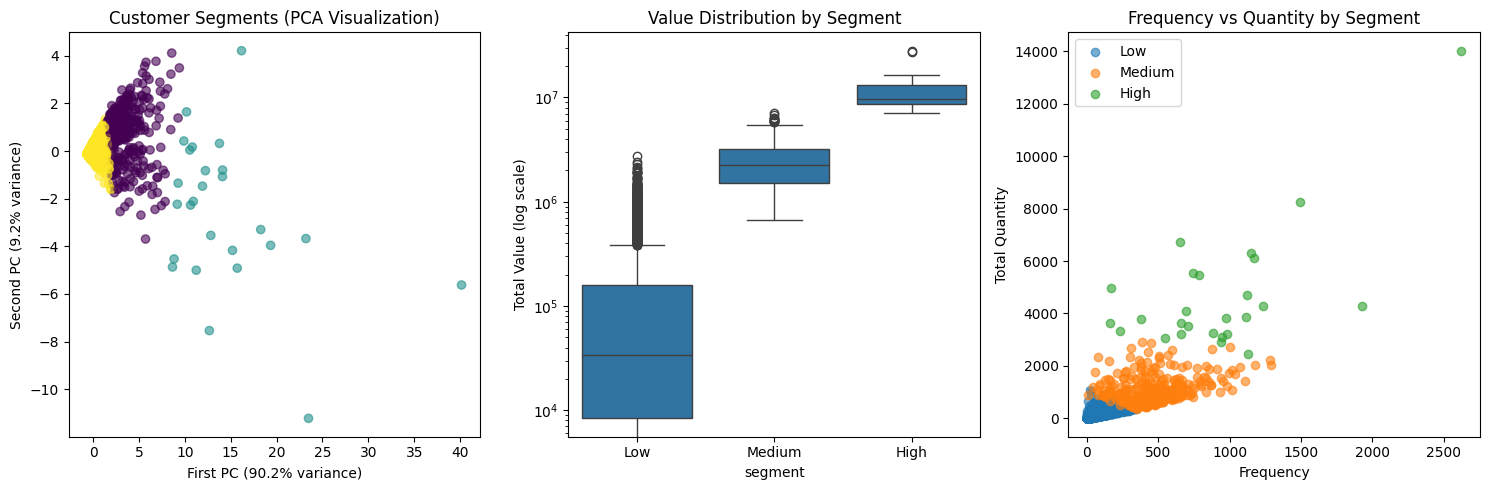

In [20]:
# Perform segmentation
business_metrics, X_scaled, X_pca, kmeans, explained_variance = perform_customer_segmentation(data)

# Create visualizations
fig = plot_segmentation_results(business_metrics, X_pca, kmeans, explained_variance)

# Get segment statistics
segment_stats = analyze_segments(business_metrics)
print("\nSegment Statistics:")
print(segment_stats)

# Get detailed segment characteristics
characteristics = get_segment_characteristics(business_metrics)
print("\nSegment Characteristics:")
print(characteristics)

### 2. Forecasting (ARIMA)

In [21]:
def prepare_time_series(monthly_df):
  monthly_series = monthly_df["VALUE"]

  return monthly_series

In [22]:
pd.set_option('display.float_format', '{:.2f}'.format)
def arima_analysis(series, order=(1,1,1), forecast_steps=3):
    model = ARIMA(series.values, order=order)
    model_results = model.fit()

    # Forecast
    forecast = model_results.forecast(steps=forecast_steps)
    forecast_dates = pd.date_range(start=series.index[-1], periods=forecast_steps + 1, freq='M')[1:]
    forecast_df = pd.DataFrame({"Forecast": forecast}, index=forecast_dates)

    # Confidence Intervals
    forecast_ci = model_results.get_forecast(steps=forecast_steps).conf_int()
    # Convert forecast_ci to DataFrame for using iloc
    forecast_ci = pd.DataFrame(forecast_ci, index=forecast_dates)

    # Model Diagnostics
    diagnostics = {
        'AIC': model_results.aic,
        'BIC': model_results.bic,
        'MAPE': mean_absolute_percentage_error(series, model_results.fittedvalues) * 100  # Converting to percentage
    }

        # Plotting
    plt.figure(figsize=(12, 6))

    # Plot historical data
    plt.plot(series.index, series.values, label='Historical Sales')

    # Plot forecast
    plt.plot(forecast_df.index, forecast_df['Forecast'], 'r--', label='Forecast')

    # Plot confidence intervals
    plt.fill_between(forecast_df.index,
                     forecast_ci.iloc[:, 0],
                     forecast_ci.iloc[:, 1],
                     color='r', alpha=0.1, label='95% Confidence Interval')

    plt.title('Total Sales Forecast')
    plt.xlabel('Date')
    plt.ylabel('Total Sales')
    plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f"{x / 1_000_000:.1f}M"))
    plt.legend()
    plt.grid(True)

    return {
        'forecast': forecast_df.round(2),
        'diagnostics': diagnostics
    }

{'forecast':                Forecast
 2025-01-31 136502396.88
 2025-02-28 137227398.41
 2025-03-31 137247026.54,
 'diagnostics': {'AIC': 414.5348216997927,
  'BIC': 415.7285075181878,
  'MAPE': 21.631519242791732}}

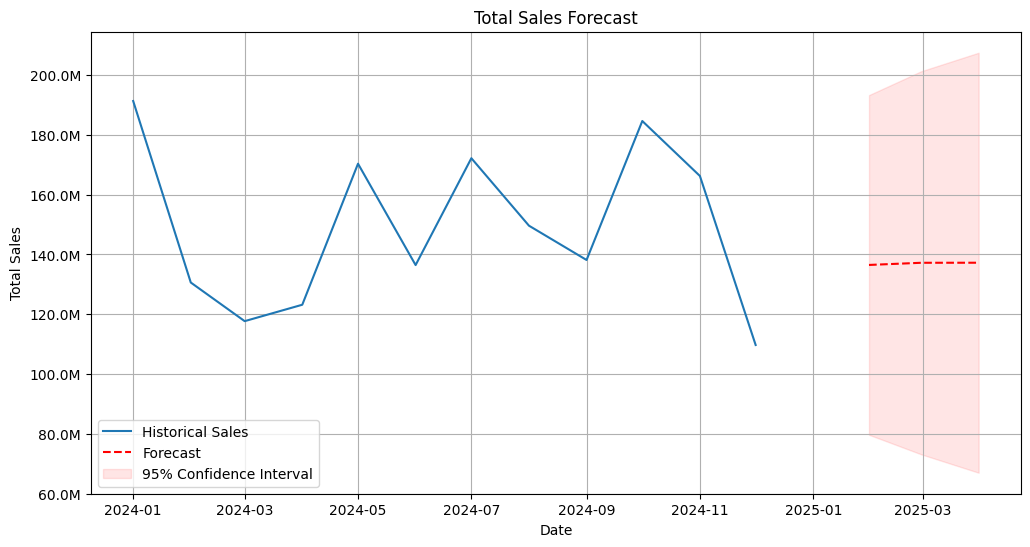

In [23]:
# Prepare time series data
monthly_series = prepare_time_series(monthly_sales)

# Running the MODEL
analysis_results = arima_analysis(monthly_series, order=(1, 1, 1), forecast_steps=3)
analysis_results

#### Business Context for the Forecast

**Sales Growth and Market Performance:**
The forecast shows an increase from 136.5 million in Total Sales in January to 137.2 million by March 2025. This indicates a positive trend in sales volume, suggesting that market demand for all products will growing, albeit gradually.

### 3. Anomaly Detection

In [24]:
# SALES ANOMALY DETECTION ANALYSIS

def prepare_daily_data(df):
    # Aggregate by date
    daily_data = df.groupby("DATE").agg({
        "QUANTITY": "sum",
        "VALUE": "sum",
        "ANONYMIZED BUSINESS": "nunique"
    }).reset_index()

    return daily_data

def detect_anomalies(series, threshold=3):
    # Calculate Z-scores
    z_scores = np.abs(stats.zscore(series))

    # IQR method
    Q1 = series.quantile(0.25)
    Q3 = series.quantile(0.75)
    IQR = Q3 - Q1
    iqr_outliers = (series < (Q1 - 1.5 * IQR)) | (series > (Q3 + 1.5 * IQR))

    # Moving average method
    rolling_mean = series.rolling(window=7).mean()
    rolling_std = series.rolling(window=7).std()
    ma_outliers = np.abs(series - rolling_mean) > (threshold * rolling_std)

    # Combine methods (mark as anomaly if detected by at least 2 methods)
    anomalies = ((z_scores > threshold) & iqr_outliers) | \
                ((z_scores > threshold) & ma_outliers) | \
                (iqr_outliers & ma_outliers)

    return anomalies, rolling_mean, rolling_std

def analyze_anomalies(df, daily_data, anomaly_dates):
    anomaly_analysis = []

    for date in anomaly_dates:
        # Get the anomaly day data
        day_data = daily_data[daily_data["DATE"] == date].iloc[0]

        # Get detailed data for the anomaly day
        day_details = df[df["DATE"] == date]

        # Calculate metrics
        analysis = {
            "Date": date,
            "Total Quantity": day_data["QUANTITY"],
            "Total Value": day_data["VALUE"],
            "Num Businesses": day_data["ANONYMIZED BUSINESS"],
            "Top Categories": day_details.groupby("ANONYMIZED CATEGORY")["QUANTITY"].sum().nlargest(3).index.tolist(),
            "Top Products": day_details.groupby("ANONYMIZED PRODUCT")["QUANTITY"].sum().nlargest(3).index.tolist(),
            "Top Locations": day_details.groupby("ANONYMIZED LOCATION")["QUANTITY"].sum().nlargest(3).index.tolist()
        }

        anomaly_analysis.append(analysis)

    return pd.DataFrame(anomaly_analysis)

def plot_anomalies(daily_data, quantity_anomalies, value_anomalies):
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 10))

    # Plot Quantity anomalies
    ax1.plot(daily_data["DATE"], daily_data["QUANTITY"], label="Daily Quantity")
    ax1.scatter(daily_data[quantity_anomalies]["DATE"],
                daily_data[quantity_anomalies]["QUANTITY"],
                color="red", label="Anomalies")
    ax1.set_title("Daily Quantity with Anomalies")
    ax1.set_xlabel("Date")
    ax1.set_ylabel("Quantity")
    ax1.legend()

    # Plot Value anomalies
    ax2.plot(daily_data["DATE"], daily_data["VALUE"], label="Daily Value")
    ax2.scatter(daily_data[value_anomalies]["DATE"],
                daily_data[value_anomalies]["VALUE"],
                color="red", label="Anomalies")
    ax2.set_title("Daily Sales Value with Anomalies")
    ax2.set_xlabel("Date")
    ax2.set_ylabel("Sales Value")
    ax2.legend()

    plt.tight_layout()
    return fig

def analyze_anomaly_patterns(df, daily_data, anomalies):
    patterns = {
        "Day of Week": daily_data[anomalies]["DATE"].dt.day_name().value_counts(),
        "Month": daily_data[anomalies]["DATE"].dt.month_name().value_counts(),
        "Average Normal Day": {
            "Quantity": daily_data[~anomalies]["QUANTITY"].mean(),
            "Value": daily_data[~anomalies]["VALUE"].mean(),
            "Num Businesses": daily_data[~anomalies]["ANONYMIZED BUSINESS"].mean()
        },
        "Average Anomaly Day": {
            "Quantity": daily_data[anomalies]["QUANTITY"].mean(),
            "Value": daily_data[anomalies]["VALUE"].mean(),
            "Num Businesses": daily_data[anomalies]["ANONYMIZED BUSINESS"].mean()
        }
    }

    return patterns

def generate_summary_report(daily_data, quantity_anomalies, value_anomalies, anomaly_analysis):
    summary = {
        "Total Days Analyzed": len(daily_data),
        "Quantity Anomalies Found": quantity_anomalies.sum(),
        "Value Anomalies Found": value_anomalies.sum(),
        "Largest Quantity Spike": anomaly_analysis["Total Quantity"].max(),
        "Largest Value Spike": anomaly_analysis["Total Value"].max(),
        "Most Common Anomaly Categories": pd.Series([cat for cats in anomaly_analysis["Top Categories"] for cat in cats]).value_counts().head(),
        "Most Common Anomaly Locations": pd.Series([loc for locs in anomaly_analysis["Top Locations"] for loc in locs]).value_counts().head()
    }

    return summary


Summary Report:
{'Total Days Analyzed': 96703, 'Quantity Anomalies Found': 1703, 'Value Anomalies Found': 1402, 'Largest Quantity Spike': 600, 'Largest Value Spike': 3228000, 'Most Common Anomaly Categories': Category-75     1269
Category-120    1003
Category-100     709
Category-76      602
Category-119     498
Name: count, dtype: int64, 'Most Common Anomaly Locations': Location-689f    609
Location-3e32    396
Location-e2f8    243
Location-3fc0    235
Location-03fc    224
Name: count, dtype: int64}

Detailed Anomaly Analysis:
                    Date  Total Quantity  Total Value  Num Businesses  \
0    2024-01-01 15:30:00             158       320644               2   
1    2024-01-01 16:19:00              43       130750               3   
2    2024-01-01 19:08:00              69       150137               3   
3    2024-01-01 19:28:00              67       148640               3   
4    2024-01-01 20:20:00              53       101540               2   
...                  ...   

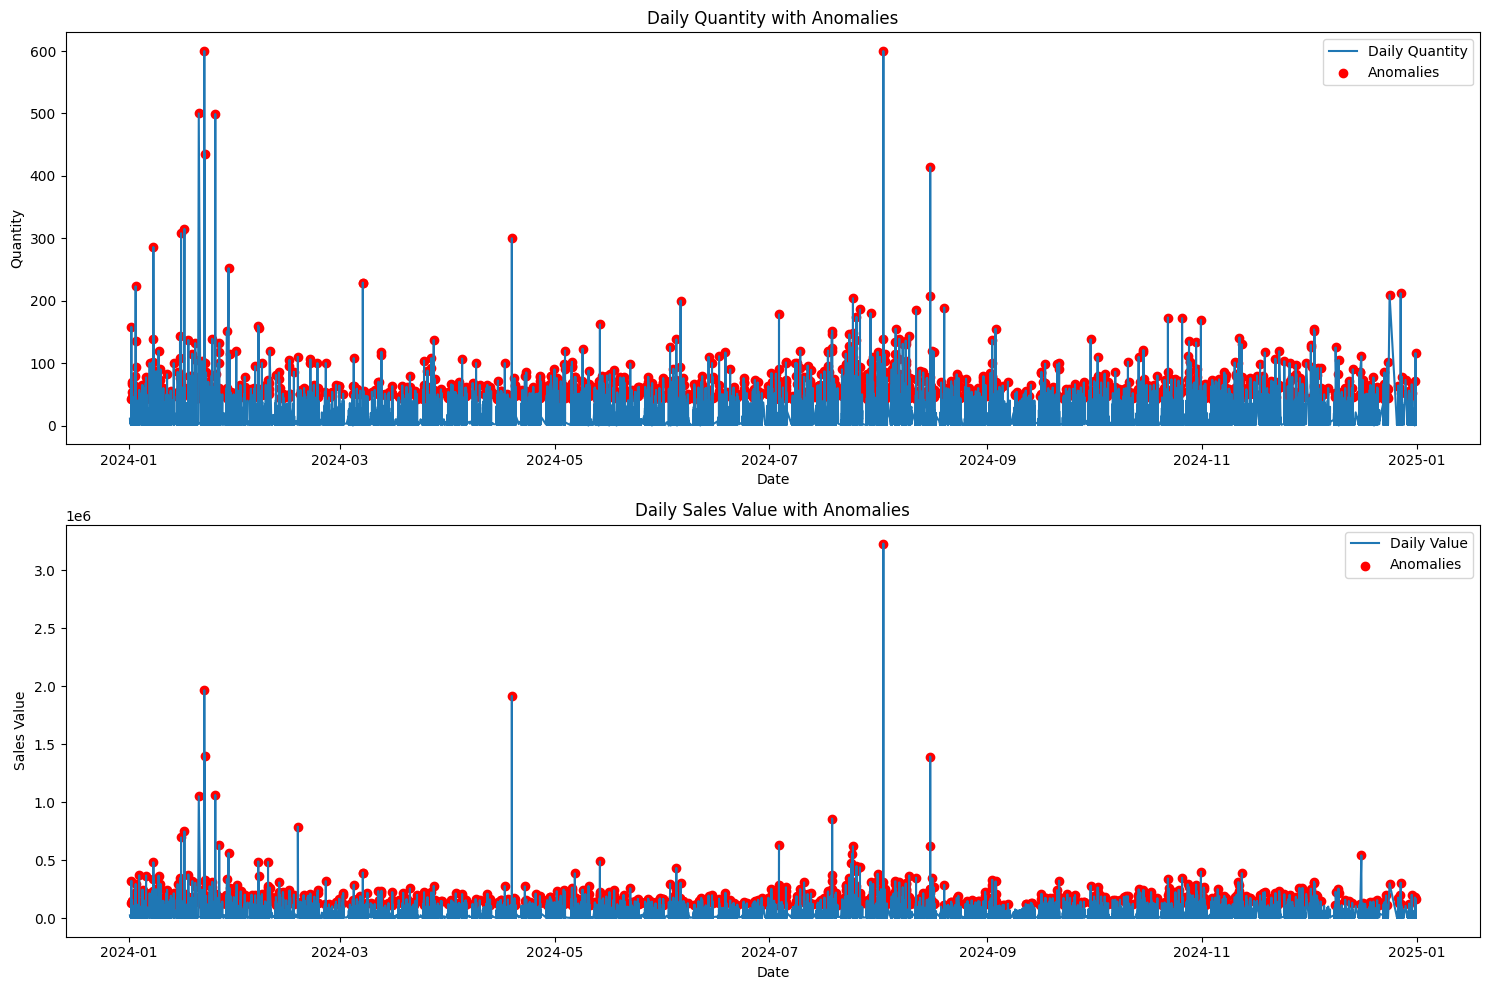

In [25]:
# rUN ANOMALLY DETECTION ANALYSIS
# Prepare daily data
daily_data = prepare_daily_data(data)

# Detect anomalies in both quantity and value
quantity_anomalies, q_rolling_mean, q_rolling_std = detect_anomalies(daily_data["QUANTITY"])
value_anomalies, v_rolling_mean, v_rolling_std = detect_anomalies(daily_data["VALUE"])

# Get dates with either quantity or value anomalies
anomaly_dates = daily_data[quantity_anomalies | value_anomalies]["DATE"].unique()

# Analyze anomalies in detail
anomaly_analysis = analyze_anomalies(data, daily_data, anomaly_dates)

# Plot anomalies
fig = plot_anomalies(daily_data, quantity_anomalies, value_anomalies)
fig.show()

# Analyze patterns
patterns = analyze_anomaly_patterns(data, daily_data, quantity_anomalies | value_anomalies)

# Generate summary report
summary = generate_summary_report(daily_data, quantity_anomalies, value_anomalies, anomaly_analysis)

print("\nSummary Report:")
print(summary)

print("\nDetailed Anomaly Analysis:")
print(anomaly_analysis)

print("\nAnomaly Patterns:")
print(patterns)

### 4. Correlation Analysis

In [26]:
data["QUANTITY"].corr(data["VALUE"])

0.8351230506192584

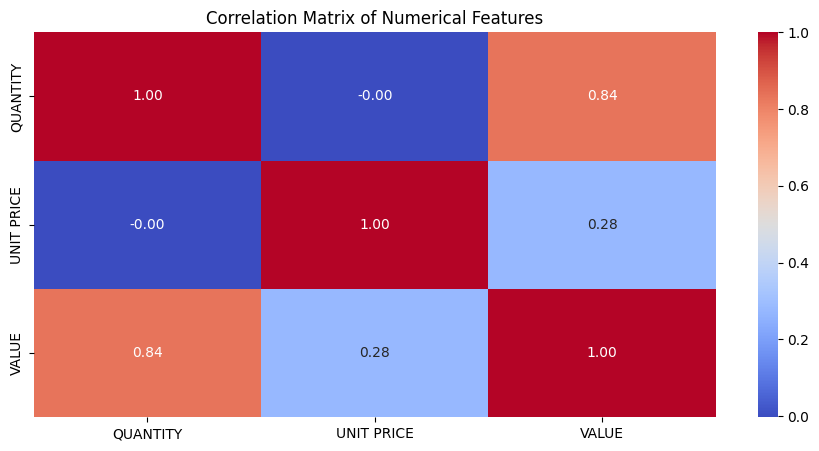

In [27]:
numerical_features = data.select_dtypes(include=np.number)
correlation_matrix = numerical_features.corr()

plt.figure(figsize=(11, 5))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Numerical Features')
plt.show()

## Section 4: Strategic Insights and Recommendations